# Deep prior inpainting 

## Libs

#### utils

In [78]:
import torch
import torch.nn as nn
import torchvision
import sys

import numpy as np
from PIL import Image
import PIL
import numpy as np

import matplotlib.pyplot as plt

def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d, 
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2), 
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped

def get_params(opt_over, net, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.
    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params

def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid
    
    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure 
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"
    
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)
    
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    
    plt.show()
    
    return grid

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img

def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size. 
    Args: 
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np



def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  np_to_torch(meshgrid)
    else:
        assert False
        
    return net_input

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.
    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.
    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.
    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
import numpy as np
from PIL import Image
import PIL
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        
        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False

#### downsampler

In [79]:
import numpy as np
import torch
import torch.nn as nn 

class Downsampler(nn.Module):
    '''
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    '''
    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None, preserve_size=False):
        super(Downsampler, self).__init__()
        
        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1/2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1./np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type in ['lanczos', 'gauss', 'box']:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'
            
            
        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        
        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch       

        self.downsampler_ = downsampler

        if preserve_size:

            if  self.kernel.shape[0] % 2 == 1: 
                pad = int((self.kernel.shape[0] - 1) / 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) / 2.)
                
            self.padding = nn.ReplicationPad2d(pad)
        
        self.preserve_size = preserve_size
        
    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x= input
        self.x = x
        return self.downsampler_(x)
        
def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box']
    
    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box': 
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])
    
        
    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1./(kernel_width * kernel_width)
        
    elif kernel_type == 'gauss': 
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        
        center = (kernel_width + 1.)/2.
        print(center, kernel_width)
        sigma_sq =  sigma * sigma
        
        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)
    elif kernel_type == 'lanczos': 
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                
                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor  
                    dj = abs(j + 0.5 - center) / factor 
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor
                
                
                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)
                
                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                
                kernel[i - 1][j - 1] = val
            
        
    else:
        assert False, 'wrong method name'
    
    kernel /= kernel.sum()
    
    return kernel

#a = Downsampler(n_planes=3, factor=2, kernel_type='lanczos2', phase='1', preserve_size=True)






#################
# Learnable downsampler

# KS = 32
# dow = nn.Sequential(nn.ReplicationPad2d(int((KS - factor) / 2.)), nn.Conv2d(1,1,KS,factor))
    
# class Apply(nn.Module):
#     def __init__(self, what, dim, *args):
#         super(Apply, self).__init__()
#         self.dim = dim
    
#         self.what = what

#     def forward(self, input):
#         inputs = []
#         for i in range(input.size(self.dim)):
#             inputs.append(self.what(input.narrow(self.dim, i, 1)))

#         return torch.cat(inputs, dim=self.dim)

#     def __len__(self):
#         return len(self._modules)
    
# downs = Apply(dow, 1)
# downs.type(dtype)(net_input.type(dtype)).size()

#### common

In [80]:
import torch
import torch.nn as nn
import numpy as np

def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
    
torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]        

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)


class GenNoise(nn.Module):
    def __init__(self, dim2):
        super(GenNoise, self).__init__()
        self.dim2 = dim2

    def forward(self, input):
        a = list(input.size())
        a[1] = self.dim2
        # print (input.data.type())

        b = torch.zeros(a).type_as(input.data)
        b.normal_()

        x = torch.autograd.Variable(b)

        return x


class Swish(nn.Module):
    """
        https://arxiv.org/abs/1710.05941
        The hype was so huge that I could not help but try it
    """
    def __init__(self):
        super(Swish, self).__init__()
        self.s = nn.Sigmoid()

    def forward(self, x):
        return x * self.s(x)


def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'Swish':
            return Swish()
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()


def bn(num_features):
    return nn.BatchNorm2d(num_features)


def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None
    if stride != 1 and downsample_mode != 'stride':

        if downsample_mode == 'avg':
            downsampler = nn.AvgPool2d(stride, stride)
        elif downsample_mode == 'max':
            downsampler = nn.MaxPool2d(stride, stride)
        elif downsample_mode  in ['lanczos2', 'lanczos3']:
            downsampler = Downsampler(n_planes=out_f, factor=stride, kernel_type=downsample_mode, phase=0.5, preserve_size=True)
        else:
            assert False

        stride = 1

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)


    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)

#### resnet

In [81]:
import torch
import torch.nn as nn
from numpy.random import normal
from numpy.linalg import svd
from math import sqrt
import torch.nn.init

class ResidualSequential(nn.Sequential):
    def __init__(self, *args):
        super(ResidualSequential, self).__init__(*args)

    def forward(self, x):
        out = super(ResidualSequential, self).forward(x)
        # print(x.size(), out.size())
        x_ = None
        if out.size(2) != x.size(2) or out.size(3) != x.size(3):
            diff2 = x.size(2) - out.size(2)
            diff3 = x.size(3) - out.size(3)
            # print(1)
            x_ = x[:, :, diff2 /2:out.size(2) + diff2 / 2, diff3 / 2:out.size(3) + diff3 / 2]
        else:
            x_ = x
        return out + x_

    def eval(self):
        print(2)
        for m in self.modules():
            m.eval()
        exit()


def get_block(num_channels, norm_layer, act_fun):
    layers = [
        nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=False),
        norm_layer(num_channels, affine=True),
        act(act_fun),
        nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=False),
        norm_layer(num_channels, affine=True),
    ]
    return layers


class ResNet(nn.Module):
    def __init__(self, num_input_channels, num_output_channels, num_blocks, num_channels, need_residual=True, act_fun='LeakyReLU', need_sigmoid=True, norm_layer=nn.BatchNorm2d, pad='reflection'):
        '''
            pad = 'start|zero|replication'
        '''
        super(ResNet, self).__init__()

        if need_residual:
            s = ResidualSequential
        else:
            s = nn.Sequential

        stride = 1
        # First layers
        layers = [
            # nn.ReplicationPad2d(num_blocks * 2 * stride + 3),
            conv(num_input_channels, num_channels, 3, stride=1, bias=True, pad=pad),
            act(act_fun)
        ]
        # Residual blocks
        # layers_residual = []
        for i in range(num_blocks):
            layers += [s(*get_block(num_channels, norm_layer, act_fun))]
       
        layers += [
            nn.Conv2d(num_channels, num_channels, 3, 1, 1),
            norm_layer(num_channels, affine=True)
        ]

        # if need_residual:
        #     layers += [ResidualSequential(*layers_residual)]
        # else:
        #     layers += [Sequential(*layers_residual)]

        # if factor >= 2: 
        #     # Do upsampling if needed
        #     layers += [
        #         nn.Conv2d(num_channels, num_channels *
        #                   factor ** 2, 3, 1),
        #         nn.PixelShuffle(factor),
        #         act(act_fun)
        #     ]
        layers += [
            conv(num_channels, num_output_channels, 3, 1, bias=True, pad=pad),
            nn.Sigmoid()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        return self.model(input)

    def eval(self):
        self.model.eval()

#### skipnet

In [82]:
import torch
import torch.nn as nn

def skip(
        num_input_channels=2, num_output_channels=3, 
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4], 
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True, 
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU', 
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.
    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')
    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down) 

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales
    
    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1 

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential()
        skip = nn.Sequential()

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)
        
        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))
            
        # skip.add(Concat(2, GenNoise(nums_noise[i]), skip_part))

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model

#### unet

In [83]:
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F

class ListModule(nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        if idx < 0: 
            idx = len(self) + idx

        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)

class UNet(nn.Module):
    '''
        upsample_mode in ['deconv', 'nearest', 'bilinear']
        pad in ['zero', 'replication', 'none']
    '''
    def __init__(self, num_input_channels=3, num_output_channels=3, 
                       feature_scale=4, more_layers=0, concat_x=False,
                       upsample_mode='deconv', pad='zero', norm_layer=nn.InstanceNorm2d, need_sigmoid=True, need_bias=True):
        super(UNet, self).__init__()

        self.feature_scale = feature_scale
        self.more_layers = more_layers
        self.concat_x = concat_x


        filters = [64, 128, 256, 512, 1024]
        filters = [x // self.feature_scale for x in filters]

        self.start = unetConv2(num_input_channels, filters[0] if not concat_x else filters[0] - num_input_channels, norm_layer, need_bias, pad)

        self.down1 = unetDown(filters[0], filters[1] if not concat_x else filters[1] - num_input_channels, norm_layer, need_bias, pad)
        self.down2 = unetDown(filters[1], filters[2] if not concat_x else filters[2] - num_input_channels, norm_layer, need_bias, pad)
        self.down3 = unetDown(filters[2], filters[3] if not concat_x else filters[3] - num_input_channels, norm_layer, need_bias, pad)
        self.down4 = unetDown(filters[3], filters[4] if not concat_x else filters[4] - num_input_channels, norm_layer, need_bias, pad)

        # more downsampling layers
        if self.more_layers > 0:
            self.more_downs = [
                unetDown(filters[4], filters[4] if not concat_x else filters[4] - num_input_channels , norm_layer, need_bias, pad) for i in range(self.more_layers)]
            self.more_ups = [unetUp(filters[4], upsample_mode, need_bias, pad, same_num_filt =True) for i in range(self.more_layers)]

            self.more_downs = ListModule(*self.more_downs)
            self.more_ups   = ListModule(*self.more_ups)

        self.up4 = unetUp(filters[3], upsample_mode, need_bias, pad)
        self.up3 = unetUp(filters[2], upsample_mode, need_bias, pad)
        self.up2 = unetUp(filters[1], upsample_mode, need_bias, pad)
        self.up1 = unetUp(filters[0], upsample_mode, need_bias, pad)

        self.final = conv(filters[0], num_output_channels, 1, bias=need_bias, pad=pad)

        if need_sigmoid: 
            self.final = nn.Sequential(self.final, nn.Sigmoid())

    def forward(self, inputs):

        # Downsample 
        downs = [inputs]
        down = nn.AvgPool2d(2, 2)
        for i in range(4 + self.more_layers):
            downs.append(down(downs[-1]))

        in64 = self.start(inputs)
        if self.concat_x:
            in64 = torch.cat([in64, downs[0]], 1)

        down1 = self.down1(in64)
        if self.concat_x:
            down1 = torch.cat([down1, downs[1]], 1)

        down2 = self.down2(down1)
        if self.concat_x:
            down2 = torch.cat([down2, downs[2]], 1)

        down3 = self.down3(down2)
        if self.concat_x:
            down3 = torch.cat([down3, downs[3]], 1)

        down4 = self.down4(down3)
        if self.concat_x:
            down4 = torch.cat([down4, downs[4]], 1)

        if self.more_layers > 0:
            prevs = [down4]
            for kk, d in enumerate(self.more_downs):
                # print(prevs[-1].size())
                out = d(prevs[-1])
                if self.concat_x:
                    out = torch.cat([out,  downs[kk + 5]], 1)

                prevs.append(out)

            up_ = self.more_ups[-1](prevs[-1], prevs[-2])
            for idx in range(self.more_layers - 1):
                l = self.more_ups[self.more - idx - 2]
                up_= l(up_, prevs[self.more - idx - 2])
        else:
            up_= down4

        up4= self.up4(up_, down3)
        up3= self.up3(up4, down2)
        up2= self.up2(up3, down1)
        up1= self.up1(up2, in64)

        return self.final(up1)



class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, norm_layer, need_bias, pad):
        super(unetConv2, self).__init__()

        print(pad)
        if norm_layer is not None:
            self.conv1= nn.Sequential(conv(in_size, out_size, 3, bias=need_bias, pad=pad),
                                       norm_layer(out_size),
                                       nn.ReLU(),)
            self.conv2= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       norm_layer(out_size),
                                       nn.ReLU(),)
        else:
            self.conv1= nn.Sequential(conv(in_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
            self.conv2= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
    def forward(self, inputs):
        outputs= self.conv1(inputs)
        outputs= self.conv2(outputs)
        return outputs


class unetDown(nn.Module):
    def __init__(self, in_size, out_size, norm_layer, need_bias, pad):
        super(unetDown, self).__init__()
        self.conv= unetConv2(in_size, out_size, norm_layer, need_bias, pad)
        self.down= nn.MaxPool2d(2, 2)

    def forward(self, inputs):
        outputs= self.down(inputs)
        outputs= self.conv(outputs)
        return outputs


class unetUp(nn.Module):
    def __init__(self, out_size, upsample_mode, need_bias, pad, same_num_filt=False):
        super(unetUp, self).__init__()

        num_filt = out_size if same_num_filt else out_size * 2
        if upsample_mode == 'deconv':
            self.up= nn.ConvTranspose2d(num_filt, out_size, 4, stride=2, padding=1)
            self.conv= unetConv2(out_size * 2, out_size, None, need_bias, pad)
        elif upsample_mode=='bilinear' or upsample_mode=='nearest':
            self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode=upsample_mode),
                                   conv(num_filt, out_size, 3, bias=need_bias, pad=pad))
            self.conv= unetConv2(out_size * 2, out_size, None, need_bias, pad)
        else:
            assert False

    def forward(self, inputs1, inputs2):
        in1_up= self.up(inputs1)
        
        if (inputs2.size(2) != in1_up.size(2)) or (inputs2.size(3) != in1_up.size(3)):
            diff2 = (inputs2.size(2) - in1_up.size(2)) // 2 
            diff3 = (inputs2.size(3) - in1_up.size(3)) // 2 
            inputs2_ = inputs2[:, :, diff2 : diff2 + in1_up.size(2), diff3 : diff3 + in1_up.size(3)]
        else:
            inputs2_ = inputs2

        output= self.conv(torch.cat([in1_up, inputs2_], 1))

        return output

## Stats

In [84]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import torch
import torch.optim


torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [85]:

img_path  = '/home/fmerizzi/Documents/image_inpainting/inpainting_restoration/images/detail2_Sebastiano.png'
mask_path = '/home/fmerizzi/Documents/image_inpainting/inpainting_restoration/images/detail2_Sebastiano_mask.png'

restoration_type = "no skip"

NET_TYPE = 'skip_depth4' # one of skip_depth4|skip_depth2|UNET|ResNet

# Load mask

In [86]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [87]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

### Visualize

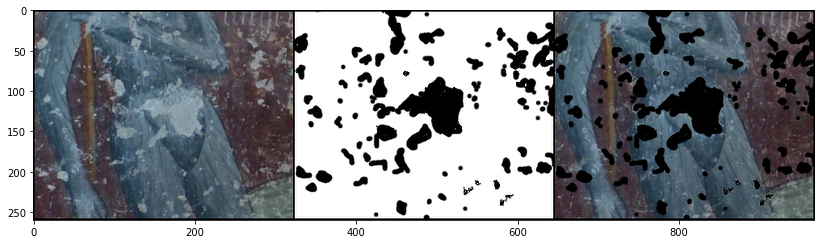

In [88]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Setup

In [71]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [89]:

if ('skip connections' in restoration_type):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise' #meshgrid
    input_depth = 32
    LR = 0.01 
    num_iter = 3001
    param_noise = False
    show_every = 500
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [256] * 5,
               num_channels_up =   [256] * 5,
               num_channels_skip =    [256] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif ('no skip' in restoration_type):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = 3001
    param_noise = False
    show_every = 500
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [256] * 5,
               num_channels_up =   [256] * 5,
               num_channels_skip =    [0] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif ('progressive' in restoration_type):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = 5001
    param_noise = False
    show_every = 500
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [32, 64, 128, 256,512],
               num_channels_up =   [32, 64, 128, 256,512],
               num_channels_skip =    [16, 32, 64, 128, 256],  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
    
elif 'architectures' in restoration_type:
    
    INPUT = 'noise'
    input_depth = 1
    
    num_iter = 3001
    show_every = 500
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True
    
    if 'skip' in NET_TYPE:
        
        depth = int(NET_TYPE[-1])
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
        LR = 0.01 
        
    elif NET_TYPE == 'UNET':
        
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
        LR = 0.001
        param_noise = False
        
    elif NET_TYPE == 'ResNet':
        
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
        LR = 0.001
        param_noise = False
        
    else:
        assert False
else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [90]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 10670099


# Main loop

Starting optimization with ADAM


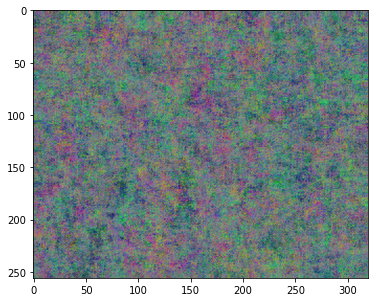

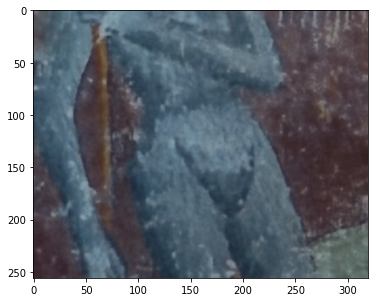

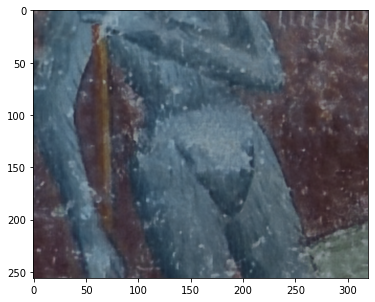

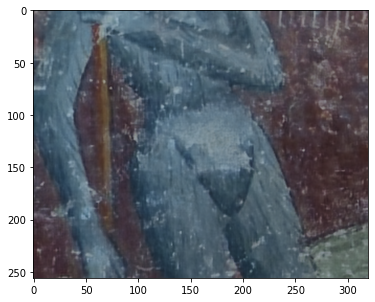

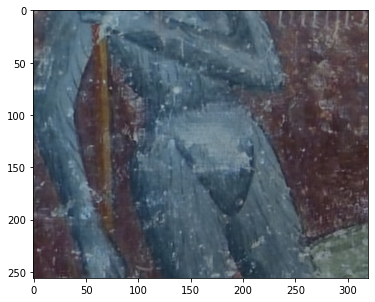

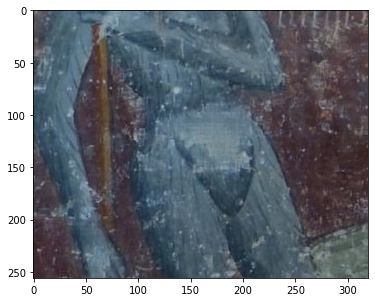

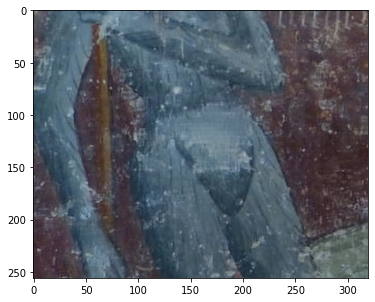

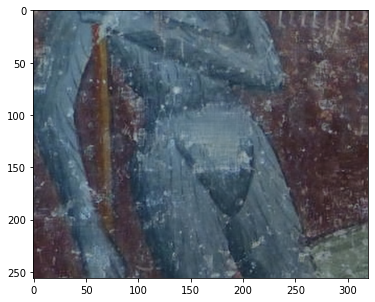

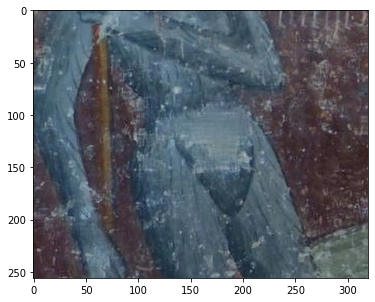

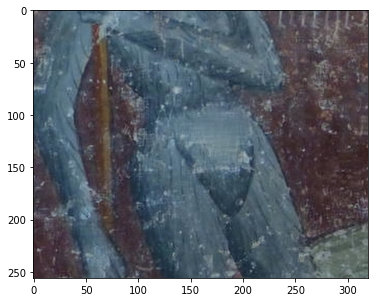

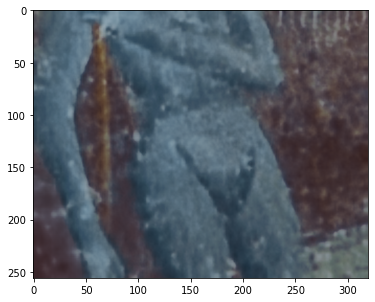

In [91]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [94]:
out_np = torch_to_np(net(net_input))
#plot_image_grid([out_np], factor=5);
#plt.imshow(out_np)

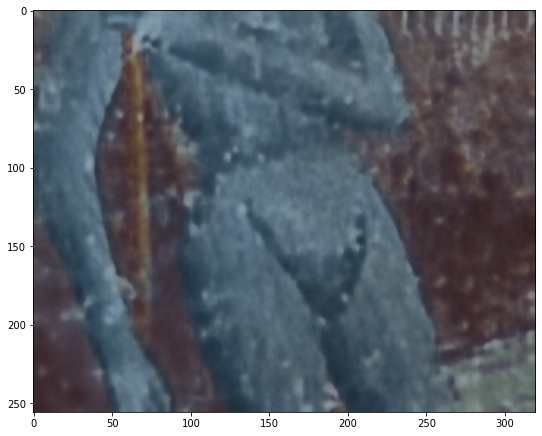

In [95]:
grid = plot_image_grid([out_np], factor=8);

In [77]:

plt.imsave('/home/fmerizzi/detail3_Sebastiano_progressive_512_256skip.jpg', grid.transpose(1, 2, 0))